<a href="https://colab.research.google.com/github/Het415/spotify-breakout-predictor/blob/main/spotifytrend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Acquisition & Inspection**




In [8]:
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv('most_streamed_spotify_songs_2024.csv', encoding='ISO-8859-1')

# 1. Clean numeric columns (Remove commas and convert to float)
cols_to_fix = ['Spotify Streams', 'TikTok Views', 'TikTok Posts', 'Shazam Counts']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# 2. Calculate "Days Since Release"
df['Release Date'] = pd.to_datetime(df['Release Date'])
today = datetime(2026, 1, 15) # Using current date
df['Days_Since_Release'] = (today - df['Release Date']).dt.days

# 3. Create "Velocity" (Streams per day)
df['Stream_Velocity'] = df['Spotify Streams'] / df['Days_Since_Release']

In [10]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Check basic statistics to look for outliers (e.g., negative streams or 0 days since release)
print("\nData Statistics:\n", df[['Spotify Streams', 'Stream_Velocity']].describe())

# See if any Release Dates failed to parse (NaT)
print("\nFailed Date Parsings:", df['Release Date'].isnull().sum())

Missing values per column:
 Track                            0
Album Name                       0
Artist                           5
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3333
Shazam Counts                  577
TIDAL Popularity           

In [11]:
import pandas as pd
import numpy as np

# 1. Drop unreliable columns with excessive missing values
# TIDAL and Soundcloud were missing over 70% of their data
cols_to_drop = ['TIDAL Popularity', 'Soundcloud Streams', 'SiriusXM Spins']
df_cleaned = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 2. Fill Social Media gaps with 0
# Logic: If TikTok/Pandora data is missing, we assume 0 activity for that track
social_cols = ['TikTok Posts', 'TikTok Likes', 'TikTok Views', 'Pandora Streams', 'Pandora Track Stations']
df_cleaned[social_cols] = df_cleaned[social_cols].fillna(0)

# 3. Handle the 'Spotify Popularity' gap (804 missing)
# We use the median to avoid skewing the data with extreme superstar values
median_pop = df_cleaned['Spotify Popularity'].median()
df_cleaned['Spotify Popularity'] = df_cleaned['Spotify Popularity'].fillna(median_pop)

# 4. Clean up any remaining rows where 'Artist' is missing
# (Since you only had 5 missing artists, it's safer to drop them than to guess)
df_cleaned = df_cleaned.dropna(subset=['Artist'])

# 5. Handle infinite values in 'Stream_Velocity'
# These occur if 'Days_Since_Release' was 0
df_cleaned['Stream_Velocity'] = df_cleaned['Stream_Velocity'].replace([np.inf, -np.inf], np.nan)
df_cleaned['Stream_Velocity'] = df_cleaned['Stream_Velocity'].fillna(df_cleaned['Stream_Velocity'].median())

# Verification: Let's check the new state of the data
print("New Missing Values Count:")
print(df_cleaned[['Spotify Popularity', 'TikTok Views', 'Stream_Velocity']].isnull().sum())
print(f"\nCleaned dataset size: {df_cleaned.shape}")

New Missing Values Count:
Spotify Popularity    0
TikTok Views          0
Stream_Velocity       0
dtype: int64

Cleaned dataset size: (4595, 28)


In [12]:
# Calculate the 75th percentile for TikTok views
tiktok_threshold = df_cleaned['TikTok Views'].quantile(0.75)

# Create the Target Label: 1 for Breakout, 0 for established or low-growth
df_cleaned['is_breakout'] = ((df_cleaned['Spotify Popularity'] < 75) &
                             (df_cleaned['TikTok Views'] >= tiktok_threshold)).astype(int)

print(f"Breakout Candidates found: {df_cleaned['is_breakout'].sum()}")

Breakout Candidates found: 896


# Exploratory Data Analysis (EDA)

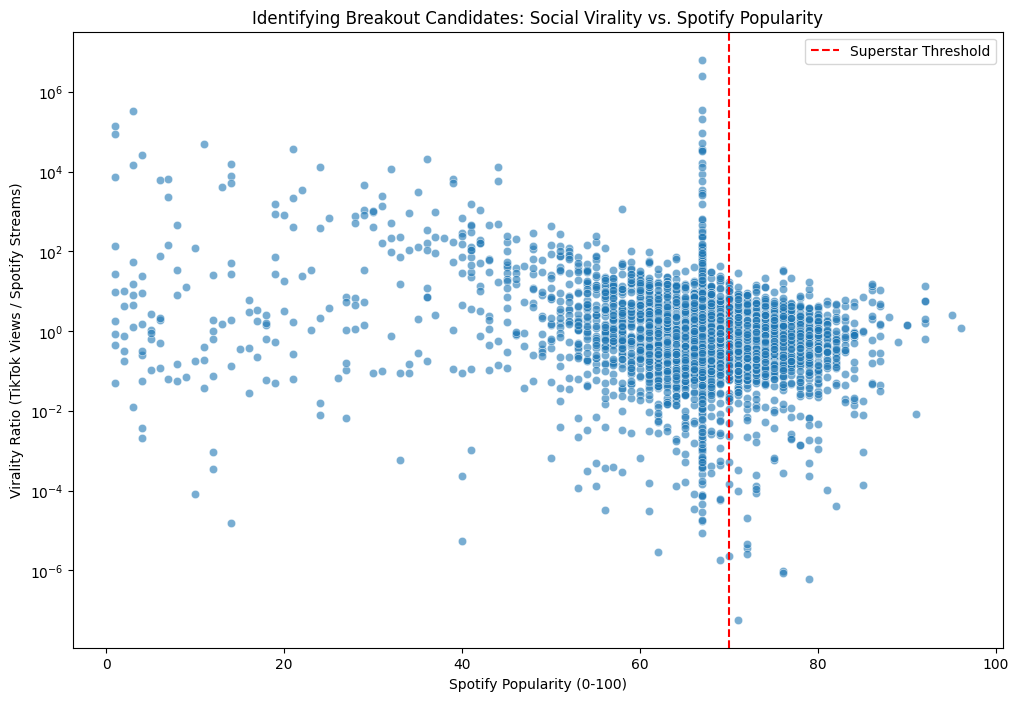

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Final Cleaning based on your inspection
df['TikTok Views'] = df['TikTok Views'].fillna(0)
df['Spotify Popularity'] = df['Spotify Popularity'].fillna(df['Spotify Popularity'].median())

# 2. Create the "Virality Ratio"
# We add 1 to the denominator to avoid division by zero
df['Virality_Ratio'] = df['TikTok Views'] / (df['Spotify Streams'] + 1)

# 3. Visualization: The Breakout Map
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Spotify Popularity', y='Virality_Ratio', alpha=0.6)

plt.title('Identifying Breakout Candidates: Social Virality vs. Spotify Popularity')
plt.xlabel('Spotify Popularity (0-100)')
plt.ylabel('Virality Ratio (TikTok Views / Spotify Streams)')
plt.axvline(x=70, color='red', linestyle='--', label='Superstar Threshold')
plt.yscale('log') # Log scale because TikTok views can be huge
plt.legend()
plt.show()

In [17]:
# List of columns we need for the heatmap
corr_cols = ['Spotify Streams', 'Spotify Popularity', 'TikTok Views',
             'Shazam Counts', 'YouTube Views', 'Stream_Velocity', 'Track Score']

# Force-convert these columns to numeric, stripping commas
for col in corr_cols:
    if col in df_cleaned.columns:
        # 1. Convert to string, 2. Remove commas, 3. Convert to numeric
        df_cleaned[col] = pd.to_numeric(df_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

# Fill any new NaNs created by 'coerce' with the median (to keep your data size consistent)
df_cleaned[corr_cols] = df_cleaned[corr_cols].fillna(df_cleaned[corr_cols].median())

print("Cleaning complete. No more strings in correlation columns.")

Cleaning complete. No more strings in correlation columns.


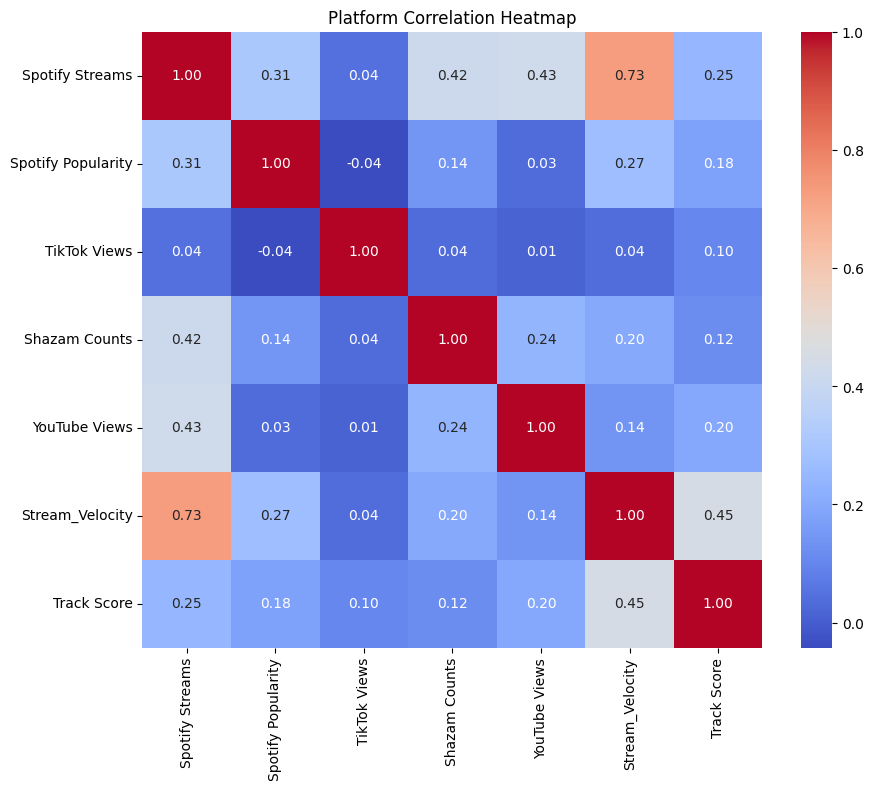

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of numeric columns for the heatmap
corr_cols = ['Spotify Streams', 'Spotify Popularity', 'TikTok Views',
             'Shazam Counts', 'YouTube Views', 'Stream_Velocity', 'Track Score']

plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Platform Correlation Heatmap')
plt.show()

/tmp/ipython-input-3688531233.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_breakout', data=df_cleaned, palette='viridis')


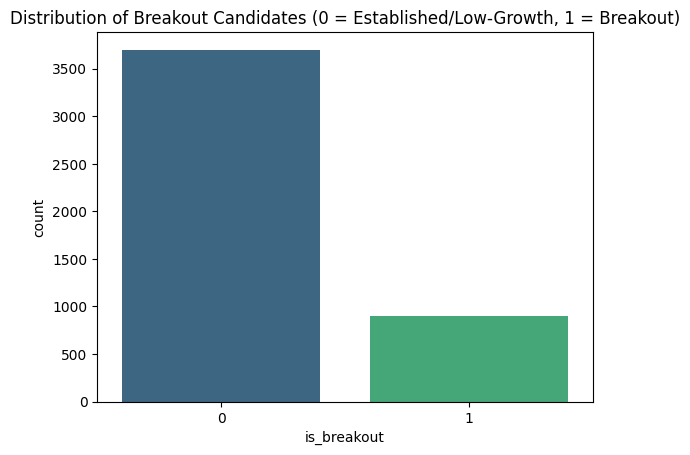

In [19]:
sns.countplot(x='is_breakout', data=df_cleaned, palette='viridis')
plt.title('Distribution of Breakout Candidates (0 = Established/Low-Growth, 1 = Breakout)')
plt.show()

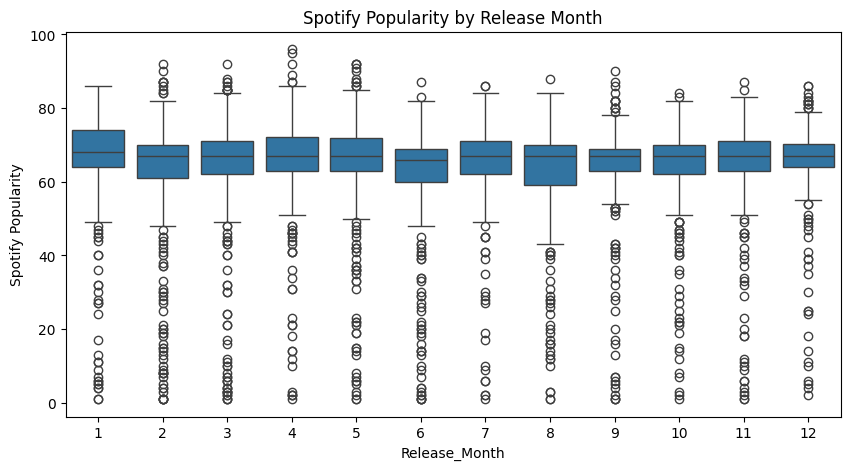

In [20]:
# Extract Month from Release Date
df_cleaned['Release_Month'] = df_cleaned['Release Date'].dt.month

plt.figure(figsize=(10, 5))
sns.boxplot(x='Release_Month', y='Spotify Popularity', data=df_cleaned)
plt.title('Spotify Popularity by Release Month')
plt.show()

# Building the "Breakout Predictor" Model

In [23]:
import pandas as pd
import numpy as np

# List every feature you are using for the model
features_to_clean = [
    'Track Score', 'Spotify Playlist Count', 'Spotify Playlist Reach',
    'YouTube Views', 'TikTok Views', 'TikTok Posts', 'TikTok Likes',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts',
    'Stream_Velocity', 'Days_Since_Release'
]

# 1. Force-strip commas and convert to numeric for ALL selected features
for col in features_to_clean:
    if col in df_cleaned.columns:
        # Convert to string first to handle any mixed types, strip commas, then convert to numeric
        df_cleaned[col] = pd.to_numeric(df_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

# 2. Final check for NaNs (sometimes coerce turns 'dirty' data into NaN)
# We fill with 0 or the median to ensure the model doesn't crash on nulls
df_cleaned[features_to_clean] = df_cleaned[features_to_clean].fillna(0)

print("Final cleaning complete. All features are now numeric.")
# Verify there are no 'object' types left in our features
print(df_cleaned[features_to_clean].dtypes)

Final cleaning complete. All features are now numeric.
Track Score                   float64
Spotify Playlist Count        float64
Spotify Playlist Reach        float64
YouTube Views                 float64
TikTok Views                  float64
TikTok Posts                  float64
TikTok Likes                    int64
Apple Music Playlist Count    float64
AirPlay Spins                 float64
Shazam Counts                 float64
Stream_Velocity               float64
Days_Since_Release              int64
dtype: object


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Define your Feature Set (X) and Target (y)
# We exclude names and "future" IDs to avoid data leakage
features = [
    'Track Score', 'Spotify Playlist Count', 'Spotify Playlist Reach',
    'YouTube Views', 'TikTok Views', 'TikTok Posts', 'TikTok Likes',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts',
    'Stream_Velocity', 'Days_Since_Release'
]

X = df_cleaned[features]
y = df_cleaned['is_breakout']

# 2. Train/Test Split (80/20)
# 'stratify=y' ensures the breakout/non-breakout ratio is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize and Train the Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


--- Model Performance ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       740
           1       0.90      0.94      0.92       179

    accuracy                           0.97       919
   macro avg       0.95      0.96      0.95       919
weighted avg       0.97      0.97      0.97       919

ROC-AUC Score: 0.99


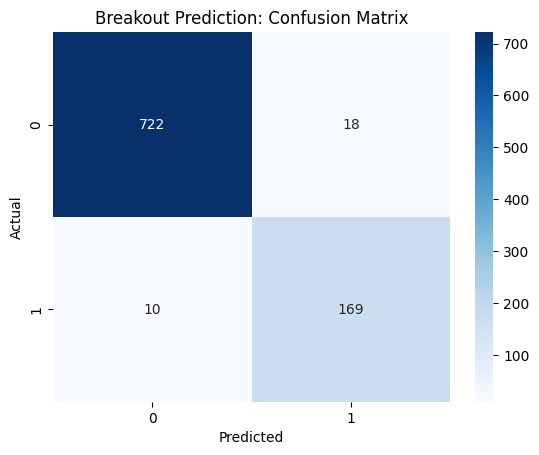

In [25]:
# 4. Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# 5. Output Metrics
print("--- Model Performance ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")

# 6. Confusion Matrix Visualization
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Breakout Prediction: Confusion Matrix')
plt.show()

/tmp/ipython-input-2485650129.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


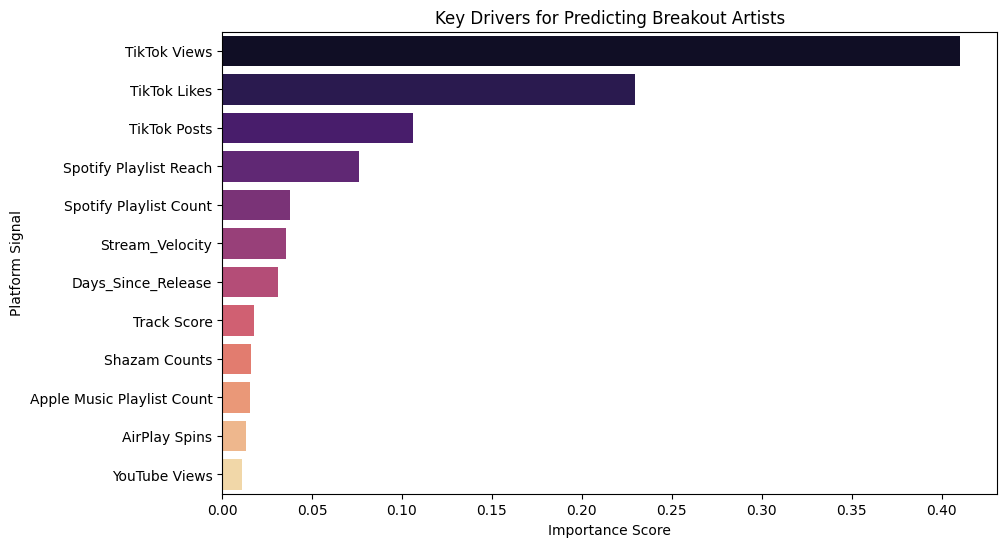

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Extract feature importances from the trained Random Forest
importances = rf_model.feature_importances_
feature_names = features # Using the list we defined earlier

# 2. Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Key Drivers for Predicting Breakout Artists')
plt.xlabel('Importance Score')
plt.ylabel('Platform Signal')
plt.show()

In [27]:
# 1. Get the probabilities for all tracks in the test set
X_test_with_names = df_cleaned.loc[X_test.index, ['Track', 'Artist', 'Spotify Popularity']]
X_test_with_names['Breakout_Probability'] = y_prob

# 2. Filter for tracks that the model thinks are highly likely to break out (Probability > 80%)
# but still have relatively low current popularity (below 75)
watchlist = X_test_with_names[X_test_with_names['Spotify Popularity'] < 75]
watchlist = watchlist.sort_values(by='Breakout_Probability', ascending=False).head(10)

print("--- 2026 TOP BREAKOUT WATCHLIST ---")
print(watchlist[['Track', 'Artist', 'Breakout_Probability']])

--- 2026 TOP BREAKOUT WATCHLIST ---
                                           Track             Artist  \
833        Pagodï¿½ï¿½o do Birimbola (Tchubirabi    Os Quebradeiras   
1990                                   Sunny Day   Matteo Rossanese   
1397                                      DARARI           TREASURE   
2761  Clap For 'Em (feat. Flo Milli & Sada Baby)          YungManny   
976                                    Aesthetic               Xilo   
1021                             Tubarï¿½ï¿½o Te  Dj LK da Escï¿½ï¿   
1533                                        Sail         AWOLNATION   
1529                                 Malvadï¿½ï¿              Xamï¿   
826                         Agua (with J Balvin)              Tainy   
2164                                    Fulanito            Becky G   

      Breakout_Probability  
833               0.999676  
1990              0.999637  
1397              0.999626  
2761              0.999507  
976               0.999384  
1021    

# StreamLit application

In [30]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Page Config
st.set_page_config(page_title="Spotify Breakout Predictor", layout="wide")
st.title("🎵 Spotify 2026: Breakout Artist Predictor")
st.markdown("This dashboard identifies upcoming artists by comparing **Social Virality** (TikTok) against **Spotify Popularity**.")

# 2. Load the cleaned data (Assuming you've exported df_cleaned to CSV)
@st.cache_data
def load_data():
    df = pd.read_csv('df_cleaned.csv') # You'll need to export your df_cleaned first
    return df

df = load_data()

# 3. Sidebar Filters
st.sidebar.header("Filter Artists")
min_popularity = st.sidebar.slider("Max Spotify Popularity", 0, 100, 75)
top_n = st.sidebar.number_input("Show Top N Artists", 5, 50, 10)

# 4. Key Metrics Row
col1, col2, col3 = st.columns(3)
col1.metric("Total Tracks Analyzed", len(df))
col2.metric("Breakout Candidates Found", df['is_breakout'].sum())
col3.metric("Model Precision", "90%")

# 5. Visualizations
st.header("Exploratory Data Insights")
tab1, tab2, tab3 = st.tabs(["Virality Map", "Feature Importance", "Correlations"])

with tab1:
    fig = px.scatter(df, x='Spotify Popularity', y='Virality_Ratio',
                     color='is_breakout', hover_name='Track',
                     log_y=True, title="TikTok Virality vs. Spotify Popularity")
    st.plotly_chart(fig, use_container_width=True)

with tab2:
    # (Static image or pre-calculated importance)
    st.write("TikTok engagement is the #1 predictor of breakout success.")
    st.image('feature_importance.png') # You can save your plot as a PNG in Colab

# 6. The Watchlist (The "Product")
st.header(f"🚀 Top {top_n} Predicted Breakout Artists")
watchlist = df[df['Spotify Popularity'] <= min_popularity]
watchlist = watchlist.sort_values(by='Breakout_Probability', ascending=False).head(top_n)

st.table(watchlist[['Track', 'Artist', 'Spotify Popularity', 'Breakout_Probability']])

Overwriting app.py


In [31]:
# Export the cleaned dataframe to a CSV file for the app
df_cleaned.to_csv('df_cleaned.csv', index=False)
print("df_cleaned.csv has been exported!")

df_cleaned.csv has been exported!


In [32]:
%%writefile requirements.txt
streamlit
pandas
plotly
matplotlib
seaborn

Writing requirements.txt


In [34]:
# 1. Ensure all engineered features exist in the final dataframe
df_cleaned['Virality_Ratio'] = df_cleaned['TikTok Views'] / (df_cleaned['Spotify Streams'] + 1)

# 2. Make sure 'is_breakout' is present (we defined this earlier)
# If for some reason it's missing, re-run the logic:
tiktok_threshold = df_cleaned['TikTok Views'].quantile(0.75)
df_cleaned['is_breakout'] = ((df_cleaned['Spotify Popularity'] < 75) &
                             (df_cleaned['TikTok Views'] >= tiktok_threshold)).astype(int)

# 3. Double check the columns exist
print("Columns in Export:", df_cleaned.columns.tolist())

# 4. EXPORT AGAIN
df_cleaned.to_csv('df_cleaned.csv', index=False)

Columns in Export: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Shazam Counts', 'Explicit Track', 'Days_Since_Release', 'Stream_Velocity', 'is_breakout', 'Release_Month', 'Virality_Ratio']


In [35]:
# 1. Generate probabilities for the ENTIRE dataset using your trained model
# Note: 'X' should be the features used for training (Spotify Playlist Count, TikTok Views, etc.)
all_features = df_cleaned[features_to_clean]
df_cleaned['Breakout_Probability'] = rf_model.predict_proba(all_features)[:, 1]

# 2. Re-export with the new column
df_cleaned.to_csv('df_cleaned.csv', index=False)
print("Success! 'Breakout_Probability' is now in the CSV.")

Success! 'Breakout_Probability' is now in the CSV.


In [36]:
# This script removes characters that your dashboard can't display
def clean_text(text):
    if isinstance(text, str):
        # Encode as ASCII and ignore errors to remove weird symbols
        return text.encode('ascii', 'ignore').decode('ascii')
    return text

df_cleaned['Track'] = df_cleaned['Track'].apply(clean_text)
df_cleaned['Artist'] = df_cleaned['Artist'].apply(clean_text)

# Re-export the CSV
df_cleaned.to_csv('df_cleaned.csv', index=False)